In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [15]:
import sys
from copy import deepcopy

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

sys.path.append("/app")
from visualizations.scripts.drawer import russia_plots

gpd.options.io_engine = "pyogrio"


def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = StandardScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


def get_high_silhoute(input_df: pd.DataFrame):
    clusters_range = range(2, 21)
    silhoute_result = dict()
    # data = pca95(input_df)
    data = input_df

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhoute_result[i] = silhouette_avg

    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(15, 8))

    x = list(silhoute_result.keys())
    y = list(silhoute_result.values())

    ax.plot(x, y, "-")
    line_x = x[np.argmax(y)]
    ax.axvline(x=line_x, color="r")

    ax.set_xlabel("Количество кластеров, шт.", fontsize=14)
    ax.set_ylabel("Величина силуэта", fontsize=14)
    ax.set_title(f"Максимальная величина силуэта найдена для {line_x} кластеров", fontsize=14)
    ax.xaxis.set_major_locator(ticker.FixedLocator(locs=[i for i in range(1, 21)]))
    ax.set_xticklabels([f"{i}" for i in range(1, 21)])

    plt.setp(ax.get_yticklabels(), fontsize=10)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    ax.grid(False)
    plt.show()

    return fig


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "< 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


In [8]:
gauges_file = gpd.read_file("/app/data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")

ws_file = gpd.read_file("/app/data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "< 100 $км^2$",
        "100 $км^2$ - 2 000 $км^2$",
        "2 000 $км^2$ - 10 000 $км^2$",
        "10 000 $км^2$ - 50 000 $км^2$",
    ],
)
ws_file = ws_file[ws_file["new_area"] <= 50000]

basemap_data = gpd.read_file("/app/data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("/app/data/geometry/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})


In [9]:
reasonable_gauges = pd.read_csv("/app/data/tables/LSTM_no_static_res.csv")
reasonable_gauges = reasonable_gauges["gauge_id"].astype(str).values
reasonable_gauges = [i for i in reasonable_gauges if i in ws_file.index]

# select only few points
gauges_file = gauges_file.loc[reasonable_gauges, :]
ws_file = ws_file.loc[reasonable_gauges, :]

### Build clusters based on static attributes

In [20]:
static_attrs = pd.read_csv("/app/data/attributes/static_with_height.csv")

static_attrs["gauge_id"] = static_attrs["gauge_id"].astype(str)
static_attrs = static_attrs.set_index("gauge_id")

static_parameters = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "sgr_dk_sav",
    "slp_dg_sav",
    "ws_area",
    "ele_mt_sav",
]

static_attrs = static_attrs[static_parameters]

test_static = deepcopy(static_attrs)
test_static.index = test_static.index.astype(str)

test_static = test_static.loc[reasonable_gauges, :]

# test_static.loc[:, :] = StandardScaler().fit_transform(test_static.values)

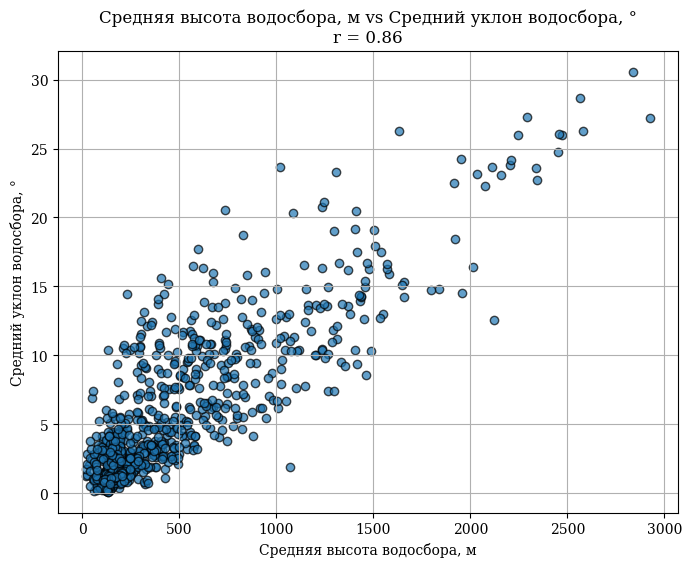

0.8624675380246803

In [25]:
def scatter_plot_with_r(df, col1, col2, x_name=None, y_name=None):
    """Generate a scatter plot of two DataFrame columns and computes the Pearson correlation coefficient.

    Parameters
    ----------
        df (pd.DataFrame): The input DataFrame.
        col1 (str): The name of the first column.
        col2 (str): The name of the second column.

    Returns
    -------
        float: The Pearson correlation coefficient.

    """
    # Compute Pearson correlation coefficient
    r = df[col1].corr(df[col2])

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df[col1], df[col2], alpha=0.7, edgecolor="k")
    if x_name is not None:
        plt.xlabel(x_name)
    else:
        plt.xlabel(col1)
    if y_name is not None:
        plt.ylabel(y_name)
    else:
        plt.ylabel(col2)
    if x_name is not None and y_name is not None:
        plt.title(f"{x_name} vs {y_name}\nr = {r:.2f}")
    else:
        plt.title(f"{col1} vs {col2}\nr = {r:.2f}")
    plt.grid(True)
    plt.show()

    return r


scatter_plot_with_r(
    test_static,
    "ele_mt_sav",
    "slp_dg_sav",
    x_name="Средняя высота водосбора, м",
    y_name="Средний уклон водосбора, °",
)


#### Correlation matrix

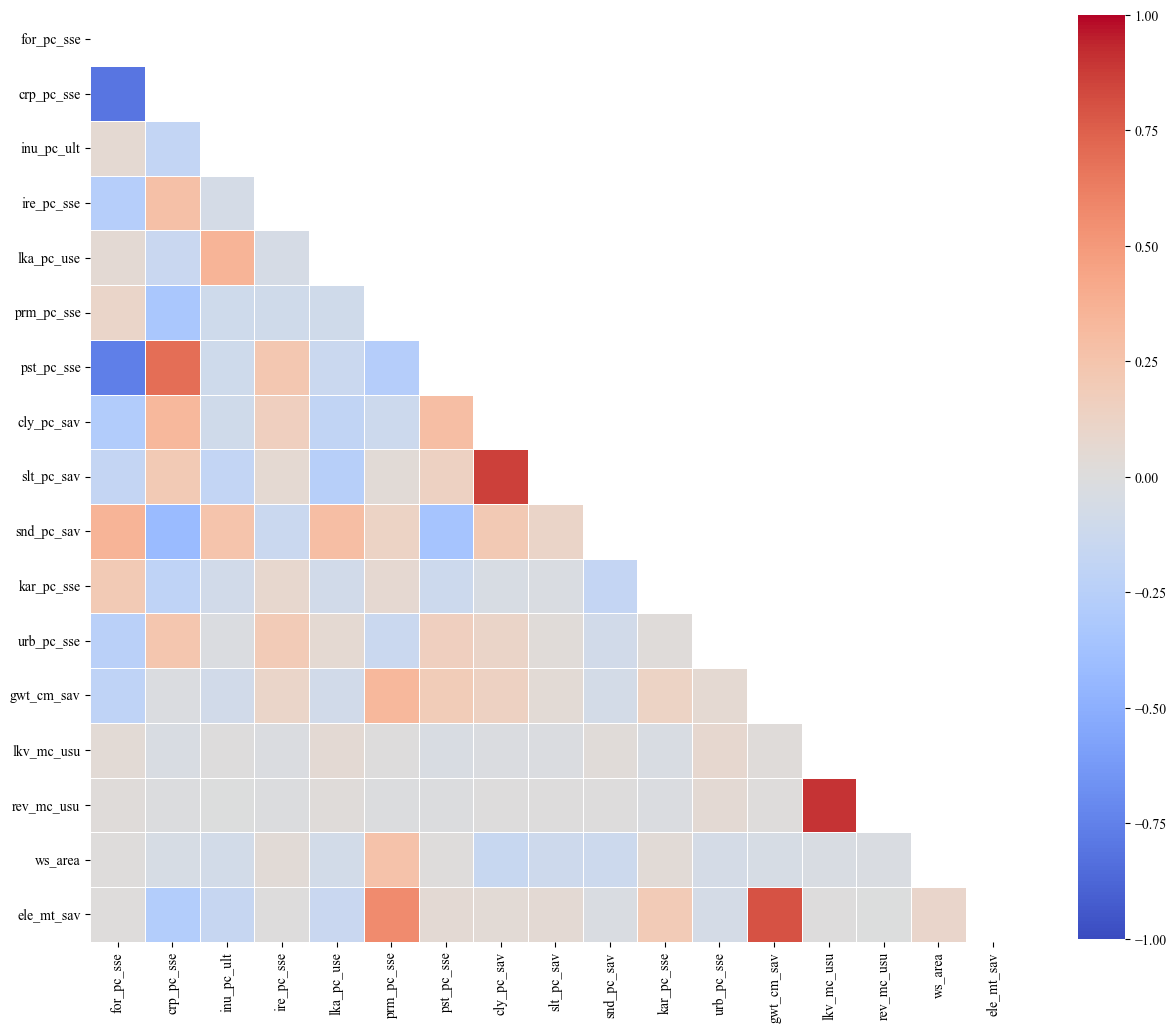

In [8]:
correlation_matrix = test_static.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    ax=ax,
    robust=True,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

#### Number of clusters

In [9]:
static_classic = get_high_silhoute(test_static)

In [11]:
km = KMeans(n_clusters=number_of_clusters, random_state=42)

yhat_AC = km.fit_predict(test_static)
test_static["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.nan
static_attrs["ResClust"] = np.nan

gauges_file = gauges_file.combine_first(test_static).dropna()
static_attrs = static_attrs.combine_first(test_static).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    # cmap_name="tab20",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=False,
)

In [38]:
cmap_name = "RdYlGn"
# cmap = mpl.colormaps.get_cmap(cmap_name)
# color_list = [
#     mcolors.rgb2hex(cmap(i)) for i in range(0, 256, 256 // number_of_clusters)
# ]
cmap = cm.get_cmap(cmap_name, number_of_clusters)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]
polar = test_static.groupby("ResClust").mean().reset_index()
polar = polar[polar["ResClust"] != 4]

polar = pd.melt(polar, id_vars=["ResClust"])


fig_polar = px.line_polar(
    polar,
    r="value",
    theta="variable",
    color="ResClust",
    color_discrete_sequence=color_list,
    template="seaborn",
    height=800,
    width=800,
)
fig_polar.update_layout(
    polar=dict(
        radialaxis=dict(showticklabels=False, ticks=""),
        angularaxis=dict(showticklabels=True, tickangle=0),
    ),
    legend_title_text="Кластеры",
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-0.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0,
    ),
)

/var/folders/t8/xsvy66jx57ngjmnmvscpw_880000gn/T/ipykernel_79847/1474344689.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



### Read Model NSE tables

In [16]:
# !TODO create more precise example

test_table = pd.read_csv("./tables/LSTM_static_res.csv", dtype={"gauge_id": str}, index_col="gauge_id")

test_table

,NSE,KGE,r,alpha,beta,RMSE,delta
gauge_id,,,,,,,
2090,0.768865,0.844381,0.880238,1.090284,1.041508,0.663670,3.633358
2103,0.729967,0.846769,0.884251,0.899837,1.007026,0.453510,0.664536
84037,-0.138326,-0.158069,0.595116,2.054187,0.743326,0.034469,-56.846309
11350,0.652255,0.721810,0.846571,1.007693,0.768073,0.162668,-64.017897
48058,0.636976,0.731890,0.901109,0.979633,0.751628,0.410430,-68.022125
...,...,...,...,...,...,...,...
3076,0.583859,0.722959,0.886649,0.748881,1.029019,0.294406,11.717790
78087,0.104186,0.481958,0.863844,1.423476,0.734487,0.054580,-52.649537
5092,0.761632,0.789375,0.883815,1.098053,0.854228,0.556445,-88.751794


In [37]:
nse_for_cluster = dict()
for i, idx in test_static.loc[test_table.index, :].groupby("ResClust").groups.items():
    nse_for_cluster[f"Cluster {i}"] = test_table.loc[idx, :]

for cluster, table in nse_for_cluster.items():
    print(f"For {cluster} NSE is equal = {table['NSE'].median()}")

For Cluster 1 NSE is equal = 0.738248407544303
For Cluster 2 NSE is equal = 0.6917138194140077
For Cluster 3 NSE is equal = 0.4011746442215814
For Cluster 5 NSE is equal = 0.7699894482379154
For Cluster 6 NSE is equal = 0.2941172150536084


In [46]:
nse_for_size = dict()
for i, idx in ws_file.loc[test_table.index, :].groupby("size", observed=True).groups.items():
    nse_for_size[f"Size {i}"] = test_table.loc[idx, :]

for size, table in nse_for_size.items():
    print(f"For {size} NSE is equal = {table['NSE'].median()}")

For Size < 100 $км^2$ NSE is equal = 0.58449441234283
For Size 100 $км^2$ - 2 000 $км^2$ NSE is equal = 0.6129740679596449
For Size 2 000 $км^2$ - 10 000 $км^2$ NSE is equal = 0.705276540641924
For Size 10 000 $км^2$ - 50 000 $км^2$ NSE is equal = 0.7886461851360171
